# Descripción

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y solicita que se evalúe esa posibilidad.
- Tarea 1: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Tarea 2: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Tarea 3: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Tarea 4: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning.


# Preprocesamiento y exploración de datos

## Inicialización

In [ ]:
pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

from scipy.spatial import distance

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
706,1,40.0,38400.0,1,0
3687,1,33.0,49600.0,0,0
673,0,21.0,34800.0,3,0
4079,0,26.0,47900.0,0,0
3186,1,36.0,39400.0,4,0
323,0,20.0,52000.0,1,0
3049,0,24.0,41200.0,0,0
566,0,21.0,34300.0,0,0
3738,1,19.0,58300.0,0,0
2160,1,20.0,50000.0,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [5]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial
df['age']=df['age'].astype('int64')
# escribe tu conversión aquí si lo deseas:

In [8]:
# comprueba que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


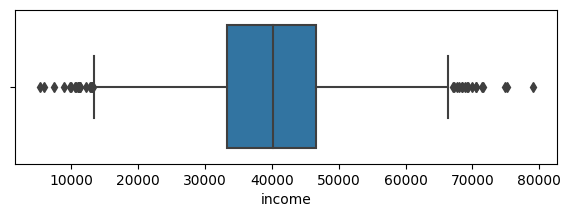

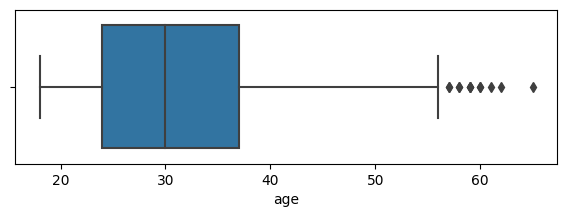

In [6]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
#Podemos tener valores atipicos en la columna income o grafiquemos el diagrama de caja y bigotes
plt.figure(figsize=(7, 2))
gr1=sns.boxplot(x='income',data=df)
plt.figure(figsize=(7, 2))
gr2=sns.boxplot(x='age',data=df)
#Todo parace lucir bien

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

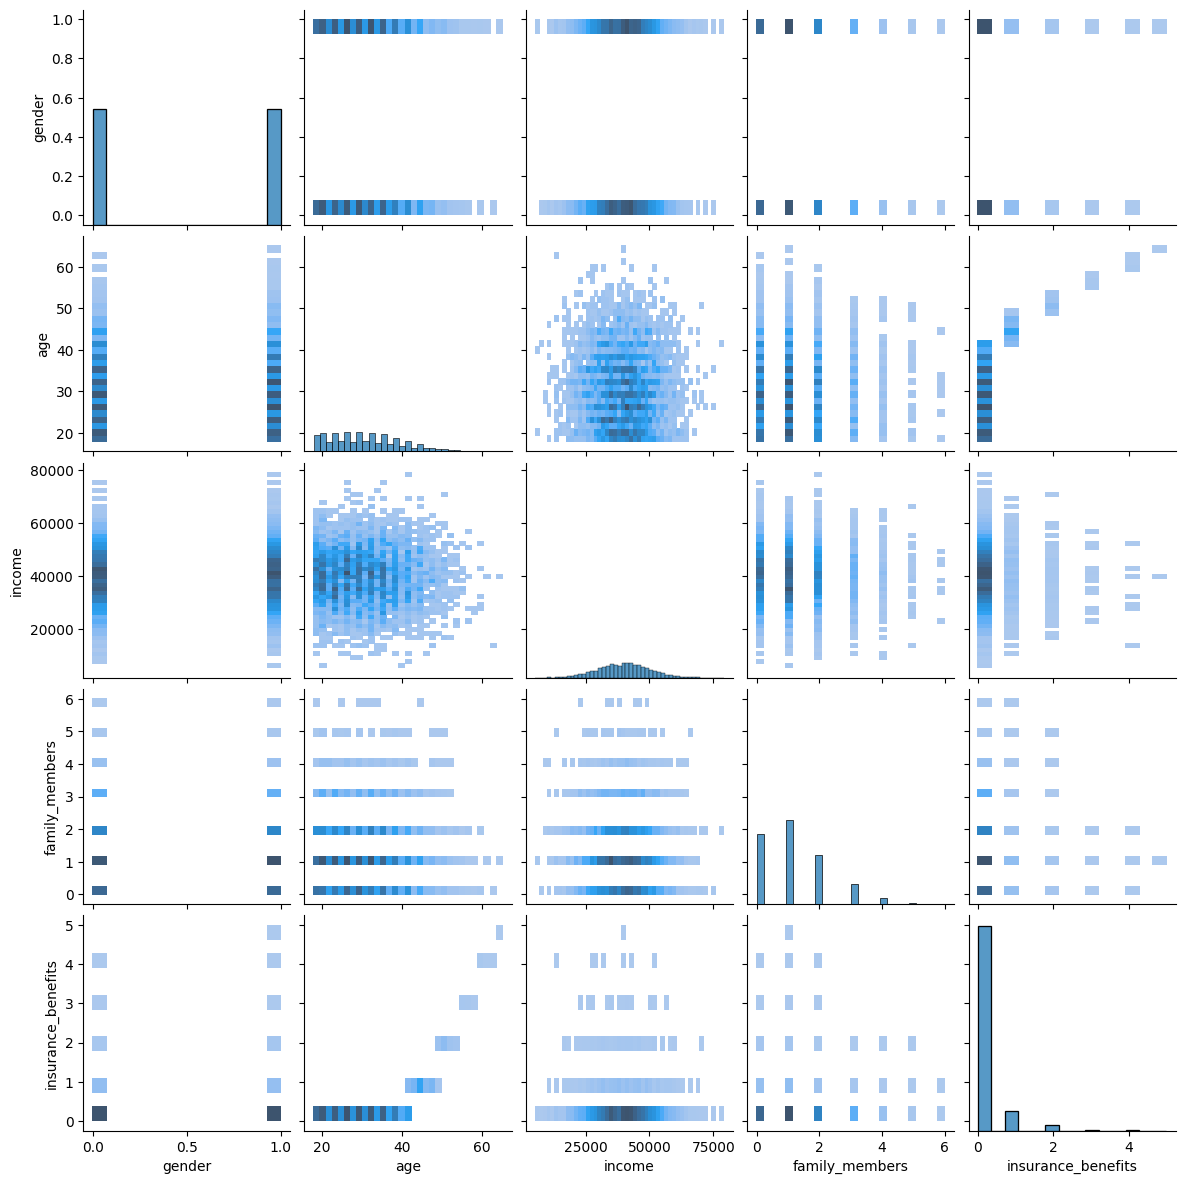

In [19]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [7]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [8]:
def get_knn(df, n, k, metric_):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric_)
    nbrs.fit(df.iloc[0:1000][feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [9]:
def get_knn(df, n, k, metric_):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """

    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric_)
    nbrs.fit(df.iloc[0:1000][feature_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names].values], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [11]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2776,1.0,0.430769,0.410127,0.166667,0
2826,0.0,0.492308,0.616456,0.333333,0
4118,1.0,0.492308,0.651899,0.333333,0
4013,0.0,0.400000,0.564557,0.333333,0
2905,0.0,0.430769,0.300000,0.333333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [12]:
display(get_knn(df_scaled,177,4,'euclidean'))

,gender,age,income,family_members,insurance_benefits,distance
177,1.0,0.861538,0.708861,0.0,3,0.000000
666,1.0,0.723077,0.692405,0.0,1,0.139436
559,1.0,0.707692,0.735443,0.0,1,0.156126
912,1.0,0.769231,0.574684,0.0,2,0.162863


In [13]:
display(get_knn(df,177,4,'euclidean'))

,gender,age,income,family_members,insurance_benefits,distance
177,1,56,56000.0,0,3,0.000000
642,0,46,56000.0,1,1,10.099505
207,0,34,55900.0,2,0,102.415819
554,1,30,56100.0,1,0,103.329570


In [14]:
display(get_knn(df_scaled,177,4,'manhattan'))

,gender,age,income,family_members,insurance_benefits,distance
177,1.0,0.861538,0.708861,0.0,3,0.000000
666,1.0,0.723077,0.692405,0.0,1,0.154917
559,1.0,0.707692,0.735443,0.0,1,0.180428
585,1.0,0.692308,0.686076,0.0,1,0.192016


In [15]:
display(get_knn(df,177,4,'manhattan'))

,gender,age,income,family_members,insurance_benefits,distance
177,1,56,56000.0,0,3,0.0
642,0,46,56000.0,1,1,12.0
207,0,34,55900.0,2,0,125.0
554,1,30,56100.0,1,0,127.0



El algoritmo kNN se ve afectado si los datos no están escalados. Podemos notar esto al fijarnos en la característica objetivo, que es la que intentamos predecir en base a la distancia. Cuando los datos están escalados, las distancias ayudan a predecir mejor nuestra característica objetivo

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Son bastante similares, solo varìan en cuanto al valor de la distancia calculada, pero el orden en cuanto a distancias se mantiene en su mayoria.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [16]:
# сalcula el objetivo
df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 1 if x>0 else 0 )

In [17]:
# comprueba el desequilibrio de clases con value_counts()
# <tu código aquí>
display(df['insurance_benefits_received'].value_counts())
#Existe un desbalance de clases, pero no se solicita abordarlo en este proyecto.

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())
df_scaled=df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())#Datos escalados
df_no_scaled=df.copy()#Datos no escalados

#Dividimos los datos
df_scaled_train,df_scaled_valid=train_test_split(df_scaled,test_size=0.30, random_state=42)
df_no_scaled_train,df_no_scaled_valid=train_test_split(df_no_scaled,test_size=0.30, random_state=42)

In [19]:
#Para encontrar los k vecinos mas cercanos
    #Buscaremos los 3 vecinos mas cercanos y obtendremos un promedio que luego transformaremos a 1 o a 0 segùn el entero mas cercano
def predictions_by_nearest_nbr(df_train,new_points,k=3):
    x_train=df_train[feature_names]
    nbr= sklearn.neighbors.NearestNeighbors(n_neighbors=k, metric='euclidean')
    nbr.fit(x_train.values)
    #Predictions
    predictions=[]
    for n in range(0,new_points.shape[0]):
        point=new_points[feature_names].iloc[[n]].values
        distances, indices = nbr.kneighbors(point)
        prediction_point=round(df_train.iloc[indices[0]]['insurance_benefits_received'].mean())#obtengo el promedio y el entero mas cercano
        predictions.append(prediction_point)
    return predictions
    

In [20]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [21]:
# generar la salida de un modelo aleatorio

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [22]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    #y_pred_rnd = get_knn(df,n,5,'manhattan').iloc[1:,:]
    y_pred_rnd = rnd_model_predict(P,df.shape[0])
        
    eval_classifier(np.array(df['insurance_benefits_received'].values), y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



In [23]:
#Usaremos kNN para testear los datos escalados
y_true=df_scaled_valid['insurance_benefits_received'].values
y_pred=predictions_by_nearest_nbr(df_scaled_train,df_scaled_valid,k=3)
eval_classifier(y_true,y_pred)

F1: 0.94
Matriz de confusión
[[0.88933333 0.00333333]
 [0.00933333 0.098     ]]


In [24]:
#Usaremos kNN para testear los datos no escalados
y_true=df_no_scaled_valid['insurance_benefits_received'].values
y_pred=predictions_by_nearest_nbr(df_no_scaled_train,df_no_scaled_valid,k=3)
eval_classifier(y_true,y_pred)

F1: 0.39
Matriz de confusión
[[0.88333333 0.00933333]
 [0.07933333 0.028     ]]


In [25]:
#probemos con diferentes valores de k y valores escalados
y_true=df_scaled_valid['insurance_benefits_received'].values
y_pred=predictions_by_nearest_nbr(df_scaled_train,df_scaled_valid,k=15)
eval_classifier(y_true,y_pred)

F1: 0.92
Matriz de confusión
[[8.92000000e-01 6.66666667e-04]
 [1.60000000e-02 9.13333333e-02]]


In [26]:
#probemos con diferentes valores de k y valores no escalados
y_true=df_no_scaled_valid['insurance_benefits_received'].values
y_pred=predictions_by_nearest_nbr(df_no_scaled_train,df_no_scaled_valid,k=15)
eval_classifier(y_true,y_pred)

F1: 0.01
Matriz de confusión
[[8.92666667e-01 0.00000000e+00]
 [1.06666667e-01 6.66666667e-04]]


A medida que k aumenta, la métrica F1 disminuye tanto para valores escalados como no escalados, en cuanto a los valores escalados, se observa un aumento signfiicativo en la calidad del model entrenado.

### Puede un modelo de predictivo funcionar mejor que un modelo dummy?
un modelo predictivo puede funcionar mejor que un modelo dummy, pero depende de la complejidad de los datos y de cómo se haya desarrollado y entrenado el modelo predictivo.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

**Implementación de un modelo de regresión lineal**

En este proyecto, estoy construyendo mi propia implementación de un modelo de regresión lineal. Para ello, me baso en la formulación clásica de la regresión lineal utilizando Álgebra Lineal. Además, estoy evaluando la precisión del modelo mediante la comparación de la raíz del error cuadrático medio (RECM) tanto para los datos en su forma original como para los datos escalados. Mi objetivo aquí es determinar si hay diferencias significativas en el desempeño del modelo en estos dos escenarios.

Aquí están los elementos clave que estoy utilizando:

- **$X$**: Esta es la matriz de características, en la que cada fila corresponde a un caso y cada columna a una característica específica. Es importante notar que la primera columna de $X$ está compuesta por unos, lo que permite incluir el término de sesgo en el modelo.
- **$y$**: Este vector representa el objetivo que el modelo tratará de predecir.
- **$\hat{y}$**: Es el vector que contiene las predicciones generadas por el modelo.
- **$w$**: Este es el vector de pesos que determina la relación entre las características en $X$ y el objetivo $y$.

La tarea de regresión lineal puede ser expresada matemáticamente de la siguiente manera:

$$
y = Xw
$$

El objetivo durante el proceso de entrenamiento es encontrar los valores óptimos para el vector $w$, minimizando la distancia L2 o, dicho de otro modo, minimizando el error cuadrático medio (ECM) entre las predicciones del modelo $Xw$ y el objetivo real $y$:

$$
\min_w d_2(Xw, y) \quad \text{o} \quad \min_w \text{MSE}(Xw, y)
$$

Es importante señalar que existe una solución analítica para este problema, que es la que estoy utilizando en este caso:

$$
w = (X^T X)^{-1} X^T y
$$

Una vez que tengo los pesos $w$, puedo utilizarlos para generar predicciones sobre nuevos datos:

$$
\hat{y} = X_{val}w
$$

Estoy documentando cuidadosamente los resultados y los análisis comparativos para asegurarme de que cualquier diferencia en la RECM entre los datos originales y los escalados sea bien comprendida y justificada.

In [27]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [28]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [29]:
Train_df, Test_df = train_test_split(df, test_size=0.3, random_state=42)

X_train = Train_df[['age', 'gender', 'income', 'family_members']].to_numpy()
y_train = Train_df['insurance_benefits'].to_numpy()
X_test = Test_df[['age', 'gender', 'income', 'family_members']].to_numpy()
y_test = Test_df['insurance_benefits'].to_numpy()

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.19740784e-01  3.54081517e-02  1.84735250e-04 -3.89692232e-07
 -1.37746920e-02]
RMSE: 0.36
R2: 0.65


In [30]:
#Usamos los datos escalados de arriba

X_train = df_scaled_train[['age', 'gender', 'income', 'family_members']].to_numpy()
y_train = df_scaled_train['insurance_benefits'].to_numpy()
X_test = df_scaled_valid[['age', 'gender', 'income', 'family_members']].to_numpy()
y_test = df_scaled_valid['insurance_benefits'].to_numpy()

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.19740784e-01  2.30152986e+00  1.84735250e-04 -3.07856864e-02
 -8.26481519e-02]
RMSE: 0.36
R2: 0.65


Se puede notar que no hay diferencias entre usar los datos escalados y los datos no escalados.En ambos casos obtenemos valores iguales en cuanto a las metricas

# Tarea 4. Ofuscar datos

**Ofuscación de datos mediante transformación matricial**

En este proyecto, estoy trabajando en la ofuscación de datos, que es una técnica crucial para proteger la información sensible mientras se mantiene la estructura subyacente de los datos para su análisis. En particular, estoy multiplicando las características numéricas, representadas por la matriz $X$, por una matriz invertible $P$ para transformar los datos.

La transformación que estoy aplicando se expresa matemáticamente de la siguiente manera:

$$
X' = X \times P
$$

Aquí, $X'$ representa la nueva matriz de características después de la transformación. Este enfoque asegura que los datos se ofusquen de manera efectiva, ya que la multiplicación por una matriz invertible $P$ cambia los valores originales de $X$ mientras preserva la posibilidad de revertir la transformación si se conoce $P$.

Es importante destacar que la propiedad de invertibilidad de $P$ es fundamental en este proceso. Si $P$ no fuera invertible, la transformación podría perder información crítica, haciendo imposible recuperar los datos originales o, en el peor de los casos, introduciendo inconsistencias en el análisis posterior.

Para asegurarme de que todo esté implementado correctamente, estoy revisando la lección sobre 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar las reglas de multiplicación de matrices y cómo implementarlas con NumPy. Esto me permitirá verificar que la matriz $P$ sea efectivamente invertible y que la transformación se esté llevando a cabo como se espera.

Una vez que aplique esta transformación, voy a comprobar cómo quedan los valores de las características después de la ofuscación para asegurarme de que la operación se realizó correctamente y que la integridad de los datos se mantiene intacta.


In [50]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [51]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [57]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [58]:
try:
    P_1=np.linalg.inv(P)
except:
    print("No es invertible")
else:
    print("Es invertible")
    print(P_1)

Es invertible
[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

In [59]:
print(X[0:4])
print(P)
print(X.dot(P)[0:4])


[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 [0.00e+00 2.10e+01 4.17e+04 2.00e+00]]
[[0.77395605 0.43887844 0.85859792 0.69736803]
 [0.09417735 0.97562235 0.7611397  0.78606431]
 [0.12811363 0.45038594 0.37079802 0.92676499]
 [0.64386512 0.82276161 0.4434142  0.22723872]]
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 [ 5345.60393712 18803.22720286 15479.14837264 38663.06186284]]


¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [60]:
print((X.dot(P)).dot(P_1)[0:5])

[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 [-4.84498208e-12  2.10000000e+01  4.17000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  2.61000000e+04 -1.01990740e-13]]


Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [61]:
print('Originial')
print((X)[0:3])
print('Transformado')
print((X.dot(P))[0:3])
print('Recuperado')
print((X.dot(P)).dot(P_1)[0:3])

Originial
[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]]
Transformado
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]]
Recuperado
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]]


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

Se debe al manejo de decimales de numpy. Cuando algùn valor deberìa ser cero, este resulta en un valor muy cercano a el.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

**Demostración analítica de la invariabilidad de la regresión lineal tras la ofuscación de datos**

En este proyecto, hemos abordado la tarea de regresión utilizando un modelo de regresión lineal. Ahora, mi siguiente objetivo es demostrar de manera analítica que la ofuscación de datos, un proceso que involucra la multiplicación de la matriz de características $X$ por una matriz invertible $P$, no afectará los valores predichos por el modelo. Esto es crucial porque, aunque pueda parecer contraintuitivo, es esencial demostrar que los valores predichos permanecen inalterados a pesar de la ofuscación.

### Descripción del Problema

Después de aplicar la ofuscación, los datos transformados se representan como $X \times P$ en lugar de $X$. Esta transformación introduce un nuevo conjunto de pesos, que denotaré como $w_P$, y que se definen de la siguiente manera:

$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

El desafío principal aquí es simplificar la expresión para $w_P$ y establecer la relación entre $w$ y $w_P$. Al hacerlo, quiero demostrar que los valores predichos utilizando $w_P$ son los mismos que los obtenidos con $w$, lo que implicaría que la ofuscación no afecta negativamente los resultados de la regresión lineal.

### Demostración Analítica

Para comenzar, partimos de la expresión para $w$ y $w_P$:

- Para $w$, tenemos:
  $$
  w = (X^T X)^{-1} X^T y
  $$

- Para $w_P$, tenemos:
  $$
  w_P = [(XP)^T XP]^{-1} (XP)^T y
  $$

Aplicando las propiedades de las matrices, podemos simplificar $w_P$:

1. Usamos la propiedad de las transpuestas $(AB)^T = B^T A^T$ y la propiedad de la inversa $(AB)^{-1} = B^{-1} A^{-1}$:
   $$
   w_P = [(P^T X^T X P)]^{-1} (P^T X^T y)
   $$

2. Descomponemos la inversa:
   $$
   w_P = (P^{-1} (X^T X)^{-1} (P^T)^{-1}) (P^T X^T y)
   $$

3. Simplificamos utilizando la propiedad de la identidad:
   $$
   w_P = P^{-1} (X^T X)^{-1} X^T y
   $$

4. Finalmente, observamos que:
   $$
   w_P = P^{-1} w
   $$

### Conclusión sobre los Valores Predichos

Dado que los valores predichos para la regresión con $w_P$ serían:

$$
\hat{y} = X w_P = X (P^{-1} w) = (X P^{-1}) w = X w
$$

Esto significa que los valores predichos son los mismos que antes de aplicar la ofuscación, lo que confirma que el proceso de ofuscación no afecta la precisión del modelo de regresión lineal.

### Implicaciones para la Calidad de la Regresión

Dado que los valores predichos no cambian, la calidad del modelo de regresión, medida mediante la raíz del error cuadrático medio (RECM), también permanecerá inalterada. Esto es fundamental para asegurar que la ofuscación de datos no comprometa la eficacia del modelo.

En resumen, he demostrado que la ofuscación de datos no afecta los resultados de la regresión lineal, lo cual refuerza la robustez y seguridad del modelo frente a posibles intentos de manipulación de datos.

Esta sección no requiere la implementación de código; es una explicación analítica que respalda la fiabilidad del modelo tras la aplicación de técnicas de ofuscación de datos.


## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

In [62]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']

In [145]:
class LinearRegressionObfuscation:
    
    def __init__(self):
        
        self.model = None
        self.rng= np.random.default_rng(seed=42)
        self.P= self.rng.random(size=(X.shape[1], X.shape[1]))
        P = rng.random(size=(X.shape[1], X.shape[1]))
        #comprobamos si es invertible
        try:
            np.linalg.inv(P)
        except:
            print("El metodo de ofucacion no esta dispoible, cambia el valor de seed")
    
    def fit(self, X, y,Obfuscation=True):
        if Obfuscation:
            X_fit_p=X.dot(self.P)
            self.model=sklearn.linear_model.LinearRegression().fit(X_fit_p,y)
        else:
            self.model=sklearn.linear_model.LinearRegression().fit(X,y)
        
    def predict(self, X,Obfuscation=True):
        
        if Obfuscation:
            X_pred_p=X.dot(self.P)
            y_pred=self.model.predict(X_pred_p)#generamos la predicciòn
            return y_pred
        else:
            y_pred1=self.model.predict(X)#generamos la predicciòn
            return y_pred1

In [109]:
#Dividimos el dataset
df_train,df_test=train_test_split(df,test_size=0.3, random_state=42)
x_train=df_train[personal_info_column_list]
x_test=df_test[personal_info_column_list]
y_train=df_train['insurance_benefits']
y_test=df_test['insurance_benefits']
#Obtenemos el conjunto de datos para entrenar el modelo y para testearlo
#----------train-------------
X_fit=x_train.to_numpy()
Y_fit=y_train.to_numpy()
#----------test--------------
X_pred=x_test.to_numpy()
Y_pred=y_test.to_numpy()

In [146]:
#creamos el modelo
model=LinearRegressionObfuscation()

In [147]:
#Entrenamos el modelo con la transformación de ofuscación elegida
model.fit(X_fit,Y_fit,True)

In [148]:
#Generamos la predicciòn
predictions=model.predict(X_pred,True)
eval_regressor(Y_pred,predictions)#obtenemos las metricas

RMSE: 0.36
R2: 0.65


In [150]:
#Entrenamos el modelo con la transformación de ofuscación desactivada
model.fit(X_fit,Y_fit,False)

In [152]:
#Generamos la predicciòn
predictions=model.predict(X_pred,False)
eval_regressor(Y_pred,predictions)#obtenemos las metricas

RMSE: 0.36
R2: 0.65


# Conclusiones

A lo largo del proyecto, se desarrollaron diversos algoritmos de machine learning para abordar tareas críticas en la industria de seguros. Se demostró que:

- **El escalado de datos mejora significativamente el rendimiento de los modelos,** logrando métricas de evaluación más altas en comparación con datos no escalados.
- **La ofuscación de datos** mediante la multiplicación de matrices es efectiva para proteger información sensible sin comprometer la precisión de los modelos de machine learning.
- **El modelo predictivo superó claramente al modelo dummy** en la tarea de clasificación, evidenciando el valor de los enfoques avanzados en la predicción de prestaciones de seguros.
- **La regresión lineal** se mostró robusta, con resultados consistentes en términos de RMSE y R², tanto con datos originales como ofuscados.

Este proyecto ilustra cómo los enfoques de machine learning pueden ser aplicados efectivamente en el sector de seguros, proporcionando soluciones prácticas y seguras.
